In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import copy
import numpy as np

import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [2]:
class DatasetMNIST(data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        data = pd.read_csv(dataset_path)
        self.xs = data.values[:, 1:].reshape(-1, 1, 28, 28)
        self.ys = data.values[:, 0]
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.xs[index], self.ys[index]
        x = torch.FloatTensor(x)
        if self.transform is not None:
            x = self.transform(x)
        y = torch.LongTensor([y])[0]
        return x, y

    def __len__(self):
        return len(self.xs)

In [3]:
class DatasetNotMNIST(data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.xs_paths = []
        self.ys = []
        for lable_num, label in enumerate(os.listdir(dataset_path)):
            lable_dir = os.path.join(dataset_path, label)
            for root, _, files in os.walk(lable_dir):
                self.ys += [lable_num] * len(files)
                self.xs_paths += list(map(lambda file: os.path.abspath(os.path.join(root, file)), files))
        self.transform = transform

    def __getitem__(self, index):
        x_path, y = self.xs_paths[index], self.ys[index]
        x = io.imread(x_path).reshape(28, 28)
        x = torch.FloatTensor([x, x, x])
        if self.transform is not None:
            x = self.transform(x)
        y = torch.LongTensor([y])[0]
        return x, y

    def __len__(self):
        return len(self.ys)

In [4]:
transform = transforms.Normalize([128.0], [255.0])
mnist = DatasetMNIST(os.path.join("..", "datasets", "mnist.csv"), transform)
not_mnist = DatasetNotMNIST(os.path.join("..", "datasets", "notMNIST_small"), transform)

In [5]:
def split_dataset(dataset, val_part=0.2):
    n = len(dataset)
    n_val = int(n * val_part)
    n_train = n - n_val
    return torch.utils.data.random_split(dataset, [n_train, n_val])

In [6]:
mnist = dict(zip(["train", "val"], split_dataset(mnist)))
not_mnist = dict(zip(["train", "val"], split_dataset(not_mnist)))

In [7]:
def train(model, dataloader, criterion, optimizer, device, num_epochs=50):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_acc = 0.0
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_acc += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_acc / len(dataloader[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                accs.append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    model.load_state_dict(best_model_wts)
    return model, accs

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class ModelMNIST(nn.Module):
    def __init__(self, function):
        super(ModelMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.fc1 = nn.Linear(8 * 22 * 22, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        if function is "sigmoid":
            self.function = nn.Sigmoid()
        elif function is "tanh":
            self.function = nn.Tanh()
        else:
            self.function = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 8 * 22 * 22)
        x = self.function(self.fc1(x))
        x = self.function(self.fc2(x))
        x = self.function(self.fc3(x))
        return x

In [10]:
mnist_loader = {x: data.DataLoader(mnist[x], 
                                   batch_size=64,
                                   shuffle=(x == "train"), 
                                   num_workers=4)
                for x in ['train', 'val']}

criterion = nn.CrossEntropyLoss()

In [11]:
accs = {}

In [12]:
function = "sigmoid"

print("Dataset: MNIST")
print("Activation function:", function)

model = ModelMNIST(function)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model, accs[function] = train(model, mnist_loader, criterion, optimizer, device)

Dataset: MNIST
Activation function: sigmoid
Epoch 0/49
----------
train Loss: 2.3032 Acc: 0.1020
val Loss: 2.3011 Acc: 0.1170

Epoch 1/49
----------
train Loss: 2.3013 Acc: 0.1126
val Loss: 2.3008 Acc: 0.1170

Epoch 2/49
----------
train Loss: 2.3006 Acc: 0.1126
val Loss: 2.3003 Acc: 0.1170

Epoch 3/49
----------
train Loss: 2.2995 Acc: 0.1126
val Loss: 2.2984 Acc: 0.1170

Epoch 4/49
----------
train Loss: 2.2956 Acc: 0.1126
val Loss: 2.2915 Acc: 0.1170

Epoch 5/49
----------
train Loss: 2.2780 Acc: 0.1335
val Loss: 2.2598 Acc: 0.2390

Epoch 6/49
----------
train Loss: 2.2370 Acc: 0.3513
val Loss: 2.2126 Acc: 0.4820

Epoch 7/49
----------
train Loss: 2.1813 Acc: 0.5614
val Loss: 2.1466 Acc: 0.6310

Epoch 8/49
----------
train Loss: 2.1065 Acc: 0.6683
val Loss: 2.0658 Acc: 0.6490

Epoch 9/49
----------
train Loss: 2.0249 Acc: 0.6985
val Loss: 1.9881 Acc: 0.7345

Epoch 10/49
----------
train Loss: 1.9532 Acc: 0.7619
val Loss: 1.9242 Acc: 0.7910

Epoch 11/49
----------
train Loss: 1.8975 

In [13]:
function = "tanh"

print("Dataset: MNIST")
print("Activation function:", function)

model = ModelMNIST(function)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model, accs[function] = train(model, mnist_loader, criterion, optimizer, device)

Dataset: MNIST
Activation function: tanh
Epoch 0/49
----------
train Loss: 1.6356 Acc: 0.6466
val Loss: 1.1551 Acc: 0.8860

Epoch 1/49
----------
train Loss: 1.0681 Acc: 0.9018
val Loss: 1.0199 Acc: 0.9140

Epoch 2/49
----------
train Loss: 0.9848 Acc: 0.9261
val Loss: 0.9787 Acc: 0.9200

Epoch 3/49
----------
train Loss: 0.9496 Acc: 0.9324
val Loss: 0.9625 Acc: 0.9295

Epoch 4/49
----------
train Loss: 0.9271 Acc: 0.9411
val Loss: 0.9499 Acc: 0.9305

Epoch 5/49
----------
train Loss: 0.9049 Acc: 0.9541
val Loss: 0.9370 Acc: 0.9345

Epoch 6/49
----------
train Loss: 0.8921 Acc: 0.9589
val Loss: 0.9342 Acc: 0.9355

Epoch 7/49
----------
train Loss: 0.8807 Acc: 0.9650
val Loss: 0.9312 Acc: 0.9345

Epoch 8/49
----------
train Loss: 0.8722 Acc: 0.9673
val Loss: 0.9250 Acc: 0.9390

Epoch 9/49
----------
train Loss: 0.8647 Acc: 0.9695
val Loss: 0.9210 Acc: 0.9395

Epoch 10/49
----------
train Loss: 0.8564 Acc: 0.9749
val Loss: 0.9196 Acc: 0.9375

Epoch 11/49
----------
train Loss: 0.8526 Acc

In [14]:
function = "relu"

print("Dataset: MNIST")
print("Activation function:", function)

model = ModelMNIST(function)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model, accs[function] = train(model, mnist_loader, criterion, optimizer, device)

Dataset: MNIST
Activation function: relu
Epoch 0/49
----------
train Loss: 1.7980 Acc: 0.4074
val Loss: 1.0224 Acc: 0.7290

Epoch 1/49
----------
train Loss: 0.6184 Acc: 0.8157
val Loss: 0.3195 Acc: 0.9085

Epoch 2/49
----------
train Loss: 0.2264 Acc: 0.9329
val Loss: 0.2327 Acc: 0.9325

Epoch 3/49
----------
train Loss: 0.1496 Acc: 0.9519
val Loss: 0.2037 Acc: 0.9430

Epoch 4/49
----------
train Loss: 0.1236 Acc: 0.9593
val Loss: 0.1913 Acc: 0.9500

Epoch 5/49
----------
train Loss: 0.0939 Acc: 0.9709
val Loss: 0.2204 Acc: 0.9390

Epoch 6/49
----------
train Loss: 0.0694 Acc: 0.9776
val Loss: 0.1894 Acc: 0.9480

Epoch 7/49
----------
train Loss: 0.0519 Acc: 0.9836
val Loss: 0.2014 Acc: 0.9470

Epoch 8/49
----------
train Loss: 0.0586 Acc: 0.9795
val Loss: 0.2107 Acc: 0.9460

Epoch 9/49
----------
train Loss: 0.0373 Acc: 0.9881
val Loss: 0.1731 Acc: 0.9585

Epoch 10/49
----------
train Loss: 0.0269 Acc: 0.9916
val Loss: 0.1888 Acc: 0.9550

Epoch 11/49
----------
train Loss: 0.0438 Acc

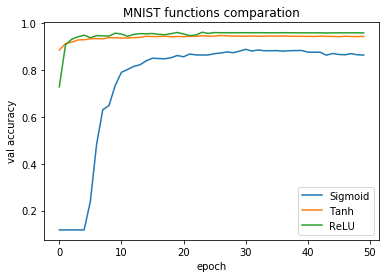

In [15]:
xs = list(range(50))
plot1, = plt.plot(xs, accs["sigmoid"])
plot2, = plt.plot(xs, accs["tanh"])
plot3, = plt.plot(xs, accs["relu"])

plt.title("MNIST functions comparation")
plt.legend([plot1, plot2, plot3], ["Sigmoid", "Tanh", "ReLU"])
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.show()

In [16]:
def get_collate_fn(add_noise=False):
    def collate_fn(data):
        xs, ys = zip(*data)
        xs = torch.stack(xs, 0)
        ys = torch.stack(ys, 0)
        if add_noise:
            xs += torch.randn_like(xs) / 10
        return xs, ys
    return collate_fn

not_mnist_loader = {x: data.DataLoader(not_mnist[x], 
                                       batch_size=32,
                                       shuffle=(x == "train"), 
                                       num_workers=4,
                                       collate_fn=get_collate_fn(x == "train"))
                    for x in ['train', 'val']}

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

model, notMNIST_accs = train(model, not_mnist_loader, criterion, optimizer, device, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.4701 Acc: 0.8726
val Loss: 0.2138 Acc: 0.9346

Epoch 1/99
----------
train Loss: 0.2966 Acc: 0.9166
val Loss: 0.1871 Acc: 0.9420

Epoch 2/99
----------
train Loss: 0.2145 Acc: 0.9335
val Loss: 0.1677 Acc: 0.9495

Epoch 3/99
----------
train Loss: 0.1988 Acc: 0.9408
val Loss: 0.1875 Acc: 0.9460

Epoch 4/99
----------
train Loss: 0.1784 Acc: 0.9477
val Loss: 0.1510 Acc: 0.9541

Epoch 5/99
----------
train Loss: 0.1422 Acc: 0.9554
val Loss: 0.1651 Acc: 0.9525

Epoch 6/99
----------
train Loss: 0.1274 Acc: 0.9591
val Loss: 0.1696 Acc: 0.9535

Epoch 7/99
----------
train Loss: 0.1473 Acc: 0.9555
val Loss: 0.1437 Acc: 0.9570

Epoch 8/99
----------
train Loss: 0.1133 Acc: 0.9651
val Loss: 0.1517 Acc: 0.9549

Epoch 9/99
----------
train Loss: 0.1554 Acc: 0.9554
val Loss: 0.1690 Acc: 0.9511

Epoch 10/99
----------
train Loss: 0.1131 Acc: 0.9641
val Loss: 0.1431 Acc: 0.9562

Epoch 11/99
----------
train Loss: 0.0983 Acc: 0.9694
val Loss: 0.1501 Acc: 0.9573

Ep

train Loss: 0.0163 Acc: 0.9950
val Loss: 0.2240 Acc: 0.9546

Epoch 99/99
----------
train Loss: 0.0168 Acc: 0.9948
val Loss: 0.2233 Acc: 0.9599



In [17]:
print("Max accuracy for notMNIST dataset:", max(notMNIST_accs))

Max accuracy for notMNIST dataset: 0.9631410256410257
